In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

##### Read the data

In [2]:
PATH = 'data'

one_p = np.loadtxt(f'{PATH}/1p.csv', dtype=np.complex128)
two_p = np.loadtxt(f'{PATH}/2p.csv', dtype=np.complex128)
three_p = np.loadtxt(f'{PATH}/3p.csv', dtype=np.complex128)
empty = np.loadtxt(f'{PATH}/empty.csv', dtype=np.complex128)
print(f"one_p.shape: {one_p.shape}")
print(f"two_p.shape: {two_p.shape}")
print(f"three_p.shape: {three_p.shape}")
print(f"empty.shape: {empty.shape}")


one_p.shape: (60, 61440)
two_p.shape: (60, 61440)
three_p.shape: (80, 61440)
empty.shape: (40, 61440)


In [3]:
one_p = one_p.reshape(one_p.shape[0], 5, 3, 64, 64)
two_p = two_p.reshape(two_p.shape[0], 5, 3, 64, 64)
three_p = three_p.reshape(three_p.shape[0], 5, 3, 64, 64)[20:, :, :, :, :]
empty = empty.reshape(empty.shape[0], 5, 3, 64, 64)
print(f"one_p.shape: {one_p.shape}")
print(f"two_p.shape: {two_p.shape}")
print(f"three_p.shape: {three_p.shape}")
print(f"empty.shape: {empty.shape}")


one_p.shape: (60, 5, 3, 64, 64)
two_p.shape: (60, 5, 3, 64, 64)
three_p.shape: (60, 5, 3, 64, 64)
empty.shape: (40, 5, 3, 64, 64)


In [35]:
def calculate_saliency_map(frames):
    differences = np.diff(frames, axis=0)
    multiplications = []
    for i in range(differences.shape[0]-1):
        multiplications.append(np.multiply(differences[i], differences[i+1]))
    multiplications = np.asarray(multiplications)
    saliency_map = np.expand_dims(np.sum(multiplications, axis=0), axis = 0)
    return differences

(5, 64, 64)
(1, 64, 64)


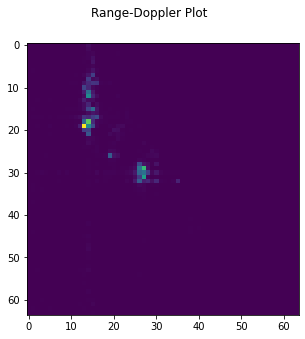

In [36]:
sample = one_p[20].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
saliency_map = calculate_saliency_map(sample)
print(saliency_map.shape)
fig, axs = plt.subplots(1, len(saliency_map), figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Range-Doppler Plot")
for i in range(1):
    to_plot = np.abs(saliency_map)[j, :, :]
    if len(saliency_map) == 1:
        axs.imshow(to_plot)
    else:
        for j in range(len(saliency_map)):
            to_plot = np.abs(saliency_map)[j, :, :] 
            axs[j].imshow(to_plot)
            axs[j].set_aspect("equal")

(5, 64, 64)
(1, 64, 64)


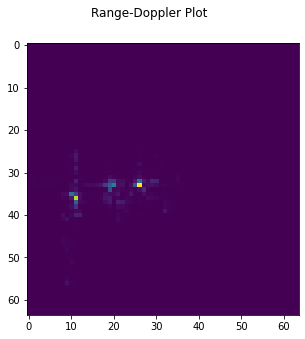

In [37]:
sample = two_p[26].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
saliency_map = calculate_saliency_map(sample)
print(saliency_map.shape)
fig, axs = plt.subplots(1, len(saliency_map), figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Range-Doppler Plot")
for i in range(1):
    to_plot = np.abs(saliency_map)[j, :, :]
    if len(saliency_map) == 1:
        axs.imshow(to_plot)
    else:
        for j in range(len(saliency_map)):
            to_plot = np.abs(saliency_map)[j, :, :] 
            axs[j].imshow(to_plot)
            axs[j].set_aspect("equal")

(5, 64, 64)
(1, 64, 64)


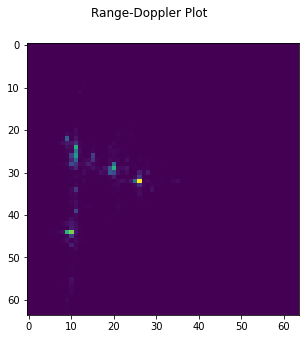

In [38]:
sample = three_p[15].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
saliency_map = calculate_saliency_map(sample)
print(saliency_map.shape)
fig, axs = plt.subplots(1, len(saliency_map), figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Range-Doppler Plot")
for i in range(1):
    to_plot = np.abs(saliency_map)[j, :, :]
    if len(saliency_map) == 1:
        axs.imshow(to_plot)
    else:
        for j in range(len(saliency_map)):
            to_plot = np.abs(saliency_map)[j, :, :]
            axs[j].imshow(to_plot)
            axs[j].set_aspect("equal")

(5, 64, 64)
(4, 64, 64)


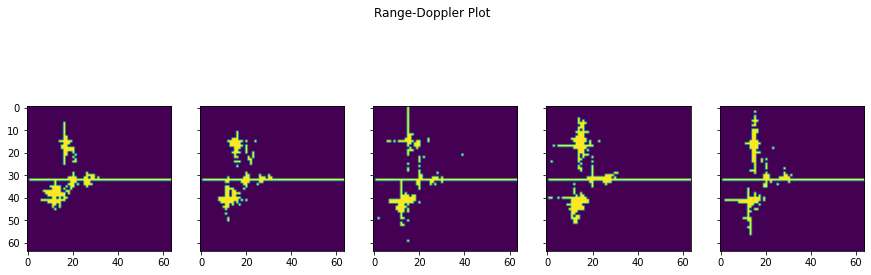

In [8]:
sample = three_p[30].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
diffs = np.diff(sample, axis=0)
print(diffs.shape)
fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Range-Doppler Plot")
for i in range(1):
    for j in range(5):
        to_plot = np.abs(sample)[j, :, :] >1
        axs[j].imshow(to_plot)
        axs[j].set_aspect("equal")

(5, 64, 64)
(1, 64, 64)


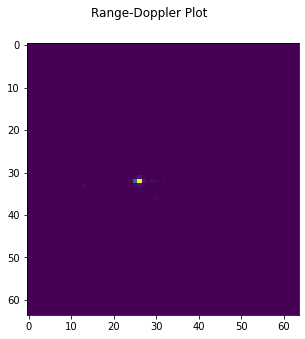

In [39]:
sample = empty[20].squeeze()
sample = np.sum(sample, axis = 1).squeeze()
print(sample.shape)
saliency_map = calculate_saliency_map(sample)
print(saliency_map.shape)
fig, axs = plt.subplots(1, len(saliency_map), figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Range-Doppler Plot")
for i in range(1):
    to_plot = np.abs(saliency_map)[j, :, :]
    if len(saliency_map) == 1:
        axs.imshow(to_plot)
    else:
        for j in range(len(saliency_map)):
            to_plot = np.abs(saliency_map)[j, :, :] 
            axs[j].imshow(to_plot)
            axs[j].set_aspect("equal")